In [74]:
from watermark_processor import WatermarkLogitsProcessor
from watermark_processor import WatermarkDetector

from datasets import load_dataset

import pickle, numpy as np, matplotlib.pyplot as plt, evaluate, pprint

PATHS = ["data/out_100_2.0.pickle", "data/out_100_3.0.pickle", "data/out_100_4.0.pickle"]
DELTAS = [2.0, 3.0, 4.0]

# Z-SCORE

In [75]:
objs = []
for i, (path, delta) in enumerate(zip(PATHS, DELTAS)):
  with open(path, "rb") as f:
    obj = pickle.load(f)
  objs.append(obj)
  
  z_score_ref = np.array([k["det_no_wm"]["z_score"] for k in obj])
  z_score_wm = np.array([k["det_wm"]["z_score"] for k in obj])
  
  if i == 0:
    print(f"Reference Evaluation")
    print(f"z, fpr, tnr")
    for z_th in [1.0, 2.0, 3.0, 4.0]:
      fpr = np.sum(z_score_ref > z_th) / len(z_score_ref)
      tnr = 1 - fpr
      print(f"{z_th}, {fpr:.4f}, {tnr:.4f}")
    
  print(f"Path: {path}, delta: {delta}")
  print(f"z, fpr, tnr, tpr, fnr")
  for z_th in [1.0, 2.0, 3.0, 4.0]:
    fpr = np.sum(z_score_ref > z_th) / len(z_score_ref)
    tnr = 1 - fpr
    tpr = np.sum(z_score_wm > z_th) / len(z_score_wm)
    fnr = 1 - tpr
    # print(f"th: {z_th}, fpr: {fpr:.4f}, tnr: {tnr:.4f}, tpr: {tpr:.4f}, fnr: {fnr:.4f}")
    print(f"{z_th}, {fpr:.4f}, {tnr:.4f}, {tpr:.4f}, {fnr:.4f}")

Reference Evaluation
z, fpr, tnr
1.0, 0.1300, 0.8700
2.0, 0.0100, 0.9900
3.0, 0.0000, 1.0000
4.0, 0.0000, 1.0000
Path: data/out_100_2.0.pickle, delta: 2.0
z, fpr, tnr, tpr, fnr
1.0, 0.1300, 0.8700, 0.7900, 0.2100
2.0, 0.0100, 0.9900, 0.5900, 0.4100
3.0, 0.0000, 1.0000, 0.3900, 0.6100
4.0, 0.0000, 1.0000, 0.1700, 0.8300
Path: data/out_100_3.0.pickle, delta: 3.0
z, fpr, tnr, tpr, fnr
1.0, 0.1000, 0.9000, 0.8800, 0.1200
2.0, 0.0000, 1.0000, 0.7300, 0.2700
3.0, 0.0000, 1.0000, 0.5800, 0.4200
4.0, 0.0000, 1.0000, 0.3900, 0.6100
Path: data/out_100_4.0.pickle, delta: 4.0
z, fpr, tnr, tpr, fnr
1.0, 0.1300, 0.8700, 0.9300, 0.0700
2.0, 0.0100, 0.9900, 0.8300, 0.1700
3.0, 0.0000, 1.0000, 0.7500, 0.2500
4.0, 0.0000, 1.0000, 0.7000, 0.3000


In [87]:
for q in objs[0][17]["data"]:
  print(f"from: {q['from']}")
  print(f"value: {q['value']}")
print("Watermark Out")
print(objs[0][17]["out_wm_text"])
print("Non-Watermark Out")
print(objs[0][17]["out_no_wm_text"])

from: human
value: Detailed Instructions: In this task, you are given a context and four options. Each option is a suggested ending for the context. You should read the context and pick the best ending for the context. Please answer with "A", "B", "C", and "D". 
Problem:[header] How to size a road bike [title] Use your total height and a road bike sizing chart for a basic guideline. [step] Standing against a wall, measure your total height and record it in centimeters, as this is how road bike frames are measured. Through an online search or by borrowing a chart at a road bike store, find the bike height that is associated with your total height. <sep> (A) Use the chart to pin down the bike height onto a pctd piece of paper. This can be applied using a graphite pencil or a ruler. (B) [substeps] If you cannot find the bike height that is in your price range, you may be able to add some information to the road bike sizing chart to help you find it. [title] Take measurements of the terrai

# ROC

In [77]:
def calculate_auc(fpr, tpr):
  """
  Calculates the AUC (Area Under the Curve) from a list of false positive rates (fpr) and true positive rates (tpr).

  Args:
      fpr (list): List of false positive rates.
      tpr (list): List of true positive rates.

  Returns:
      float: AUC value.
  """

  # Check if the lengths of the fpr and tpr lists are the same
  if len(fpr) != len(tpr):
      raise ValueError("The lengths of the fpr and tpr lists must be the same.")

  # Calculate the area of each trapezoid
  area = 0
  for i in range(1, len(fpr)):
      area += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2

  # Calculate the AUC
  auc = area

  return auc

Text(0, 0.5, 'True Positive Rate')

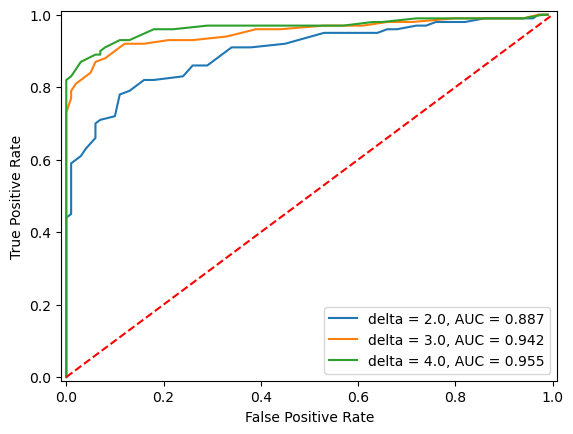

In [78]:
def create_plot(delta, z_score_wm, z_score_ref, c = ''):
  tpr_list, fpr_list = [], []
  z_low = min(z_score_ref)
  z_high = max(z_score_wm)
  for z_th in np.arange(z_high, z_low, -0.1):
      fpr = np.sum(z_score_ref > z_th) / len(z_score_ref)
      fpr_list.append(fpr)
      tpr = np.sum(z_score_wm > z_th) / len(z_score_wm)
      tpr_list.append(tpr)
  auc = calculate_auc(fpr_list, tpr_list)
  plt.plot(fpr_list, tpr_list, label=f'delta = {delta}, AUC = {auc:.3f}')

fig = plt.figure()
gamma = 0.5
for delta, obj in zip(DELTAS, objs):
  z_score_ref = np.array([k["det_no_wm"]["z_score"] for k in obj])
  z_score_wm = np.array([k["det_wm"]["z_score"] for k in obj])
  create_plot(delta, z_score_wm, z_score_ref)
# plot y = x
x = np.linspace(0, 1, 100)
y = x
plt.plot(x, y, 'r--')

plt.legend()
plt.margins(x=0.01, y = 0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# BLEU / ROGUE

In [79]:
sacrebleu = evaluate.load("sacrebleu")
rouge = evaluate.load('rouge')

In [80]:
ref = objs[0][0]["gold"]
pred_no_wm = objs[0][0]["out_no_wm_text"]
pred_wm = objs[0][0]["out_wm_text"]

In [81]:
def get_scores(pred, ref):
  bleu_score = sacrebleu.compute(predictions=pred, references=ref)
  rouge_score = rouge.compute(predictions=pred, references=ref)
  print(f"{bleu_score['score']:0.4f}, {rouge_score['rouge1'] * 100:0.4f}, {rouge_score['rouge2'] * 100:0.4f}, {rouge_score['rougeL'] * 100:0.4f}")

for obj, delta in zip(objs, DELTAS):
  ref = [q["gold"] for q in obj]
  pred_no_wm = [q["out_no_wm_text"] for q in obj]
  pred_wm = [q["out_wm_text"] for q in obj]
  print(f"=== Scores: Delta={delta} ===")
  print(f"No Watermark:")
  get_scores(pred_no_wm, ref)
  print(f"With Watermark:")
  get_scores(pred_wm, ref)

=== Scores: Delta=2.0 ===
No Watermark:
22.8867, 52.3552, 31.8885, 40.8421
With Watermark:
20.3290, 50.6647, 29.3214, 38.3931
=== Scores: Delta=3.0 ===
No Watermark:
24.0466, 54.5473, 33.3766, 43.0234
With Watermark:
19.8441, 48.6623, 27.2722, 36.6383
=== Scores: Delta=4.0 ===
No Watermark:
24.6943, 55.3776, 34.1090, 43.3023
With Watermark:
11.2578, 40.8009, 20.4021, 29.5485
